# RF Impairments

When RF signals travel through the air from a transmitter to a receiver they get affected by a great deal of channel effects which must be dealt with to recover the data. But in order to combat the impairments, we should at least understand what they look like and what causes them.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from comms_helpers import *

In [2]:
# Function to generate QPSK
def generate_qpsk(num_symbols):
    qpsk_scheme= [1+1j, 1-1j, -1+1j, -1-1j]
    ints = np.random.randint(0,4,num_symbols)
    qpsk_symbols = np.array([qpsk_scheme[i] for i in ints])/np.sqrt(2)
    
    return qpsk_symbols, ints

def make_rrc(num_weights=41, alpha=0.35, fs=5):
    Ts =  1/fs
    
    # Calculate time indexes of filter weights
    x = np.arange(-int(num_weights/2),int(num_weights/2),1)/fs
    
    # Preallocate memory for filter weights
    h_rrc = np.zeros(num_weights,)

    # Check for special cases, otherwise apply the main formula
    for idx, weight in enumerate(x):
        if weight == Ts/(4*alpha):
            h_rrc[idx] = (alpha/np.sqrt(2))*(((1+2/np.pi) * (np.sin(np.pi/(4*alpha)))) + ((1-2/np.pi)*(np.cos(np.pi/(4*alpha)))))
        elif weight == -Ts/(4*alpha):
            h_rrc[idx] = (alpha/np.sqrt(2))*(((1+2/np.pi) * (np.sin(np.pi/(4*alpha)))) + ((1-2/np.pi)*(np.cos(np.pi/(4*alpha)))))
        elif weight == 0:
            h_rrc[int(num_weights/2)] = 1/Ts*(1+alpha*(4/np.pi - 1))
        else:
            h_rrc[idx] = 1/Ts*(np.sin(np.pi*weight*(1-alpha)) + 4*alpha*weight*np.cos(np.pi*weight*(1+alpha)))/(np.pi*weight*(1-(4*alpha*weight)**2))
            
    # Normalize the weights
    h_rrc = h_rrc/np.max(h_rrc)
    
    return h_rrc

def pulse_shape(symbols, hrrc, sps=4):
    
    num_weights = len(hrrc)
    
    padded_symbols = np.zeros(len(symbols)*sps, dtype=complex)
    padded_symbols[np.arange(0,len(padded_symbols),sps)] = symbols
    
    # to take care of the transient we append a bunch of zeros
    shaped_symbols = np.convolve(np.concatenate((np.zeros(int((num_weights-1)/2)),padded_symbols)), hrrc, mode='same')
    
    return shaped_symbols[int((num_weights-1)/2):]

In [3]:
# add phase offset in degrees
def phase_offset(x, offset):
    
    # Convert to polar form so we can add degrees
    mag, ang = np.abs(x), np.angle(x, deg=True)
    
    return mag * np.exp( 1j * ((ang + offset)*np.pi/180) )

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [27]:
def savefig_predefined(*args, **kwargs):
    kwargs.setdefault('dpi', 300)
    kwargs.setdefault('bbox_inches', 'tight')
    kwargs.setdefault('format', 'png')
    return plt.savefig(*args, **kwargs)

In [5]:
noise = np.random.randn(5500,1)

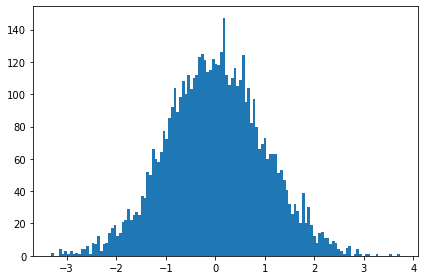

In [6]:
plt.hist(noise, bins=128)
plt.tight_layout()
plt.savefig('figures/noise.svg', dpi=300)

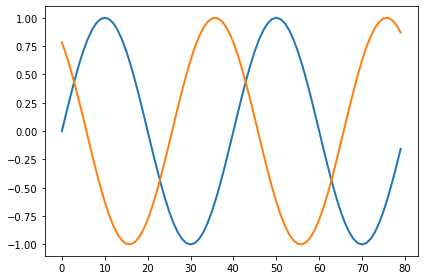

In [7]:
plt.plot(np.sin(np.arange(80)*0.05*np.pi), linewidth=2)
plt.plot(np.sin(np.arange(80)*0.05*np.pi+np.pi*5/7), linewidth=2)
plt.tight_layout()
# plt.savefig('figures/offset_vis.svg', dpi=300)

## Generate a QPSK signal

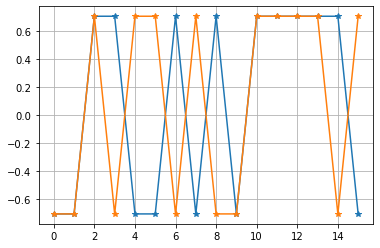

In [8]:
samples, _ = generate_qpsk(16)
plt.plot(samples.real, '-*')
plt.plot(samples.imag, '-*')
plt.grid()

Pulse shape the symbols

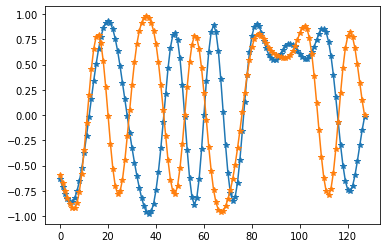

In [9]:
hrrc = make_rrc(num_weights=65, fs=8)
samples_rrc = pulse_shape(samples, hrrc, sps=8)

plt.plot(samples_rrc.real, '-*')
plt.plot(samples_rrc.imag, '-*')

Text(0.5, 1.0, 'QPSK Pulse shaped')

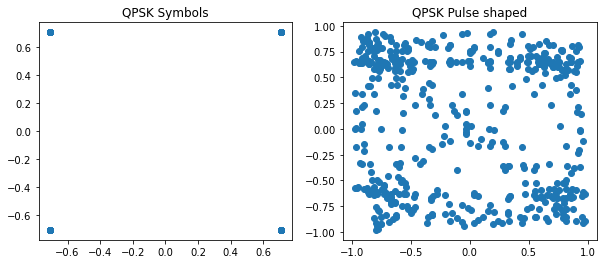

In [10]:
samples, _ = generate_qpsk(64)
hrrc = make_rrc(num_weights=65, fs=8)
samples_rrc = pulse_shape(samples, hrrc, sps=8)

fix, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(samples.real, samples.imag, 'o')
ax[0].set_title('QPSK Symbols')
ax[1].plot(samples_rrc.real, samples_rrc.imag, 'o')
ax[1].set_title('QPSK Pulse shaped')

## Clean channel

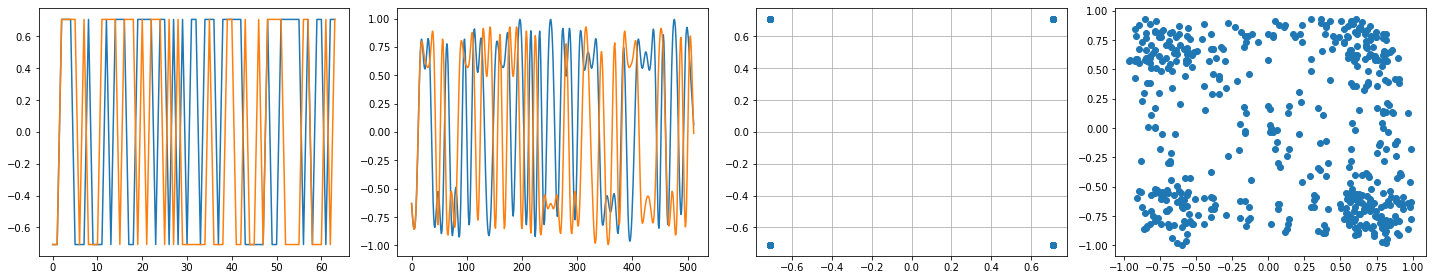

In [11]:
samples, _ = generate_qpsk(64)
hrrc = make_rrc(num_weights=65, fs=8)
samples_rrc = pulse_shape(samples, hrrc, sps=8)

fix, ax = plt.subplots(1,4,figsize=(20,4))
ax[0].plot(samples.real); ax[0].plot(samples.imag)
ax[2].plot(samples.real, samples.imag, 'o')
ax[2].grid()
ax[1].plot(samples_rrc.real); ax[1].plot(samples_rrc.imag)
ax[3].plot(samples_rrc.real, samples_rrc.imag, 'o')
plt.tight_layout()

## AWGN

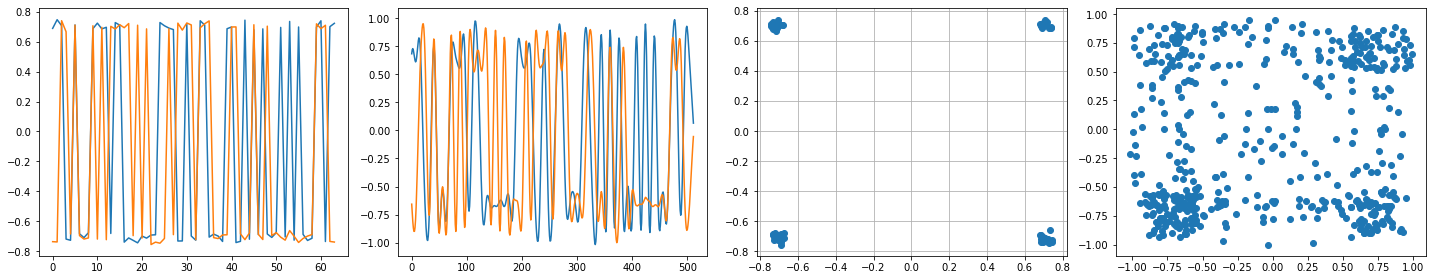

In [12]:
samples, _ = generate_qpsk(64)
samples = awgn(samples, 30)
hrrc = make_rrc(num_weights=65, fs=8)
samples_rrc = pulse_shape(samples, hrrc, sps=8)

fix, ax = plt.subplots(1,4,figsize=(20,4))
ax[0].plot(samples.real); ax[0].plot(samples.imag)
ax[2].plot(samples.real, samples.imag, 'o')
ax[2].grid()
ax[1].plot(samples_rrc.real); ax[1].plot(samples_rrc.imag)
ax[3].plot(samples_rrc.real, samples_rrc.imag, 'o')
plt.tight_layout()

## Phase offset

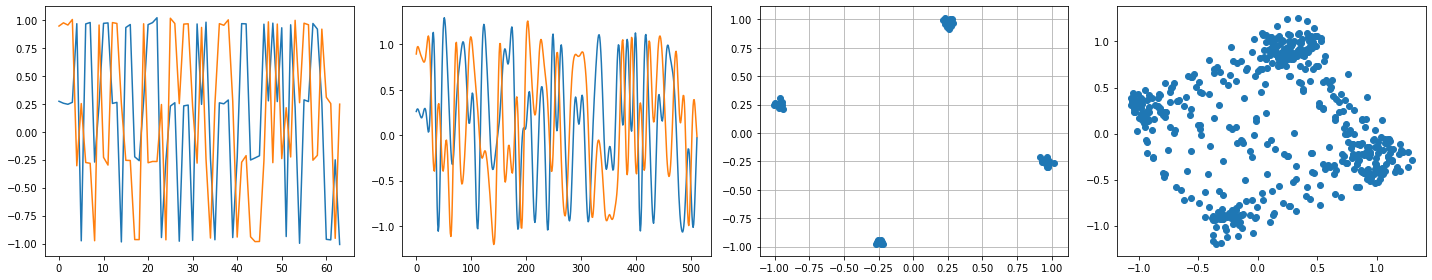

In [13]:
samples, _ = generate_qpsk(64)
samples = phase_offset(samples,offset=30)
samples = awgn(samples, 30)
hrrc = make_rrc(num_weights=65, fs=8)
samples_rrc = pulse_shape(samples, hrrc, sps=8)

fix, ax = plt.subplots(1,4,figsize=(20,4))
ax[0].plot(samples.real); ax[0].plot(samples.imag)
ax[2].plot(samples.real, samples.imag, 'o')
ax[2].grid()
ax[1].plot(samples_rrc.real); ax[1].plot(samples_rrc.imag)
ax[3].plot(samples_rrc.real, samples_rrc.imag, 'o')
plt.tight_layout()

## Frequency Offset

For a small offset $\Delta f$, constellations can still be recoverable.

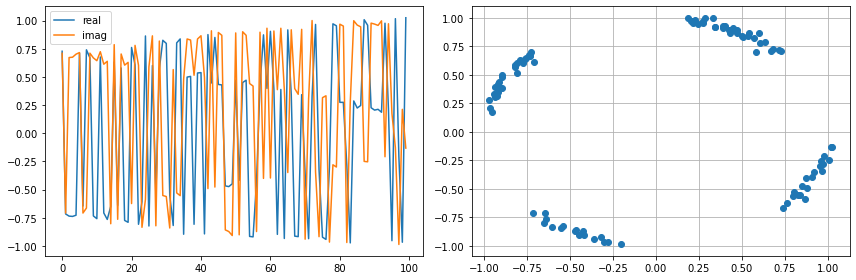

In [14]:
samples, _ = generate_qpsk(100)
# samples = np.ones(100)+1j*np.zeros(100)

offset_sine = np.exp(1j*2*np.pi*(1e3/1e6)*np.arange(len(samples)))
samples = samples*offset_sine

samples = awgn(samples,30)

fix, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(samples.real); ax[0].plot(samples.imag)
ax[1].plot(samples.real, samples.imag, 'o')
# ax[0].plot(np.angle(offset_sine)/np.pi)
# ax[0].plot(offset_sine.real)
# ax[0].plot(offset_sine.imag)
ax[1].grid()
ax[0].legend(('real', 'imag', 'sin r', 'sin i'))
plt.tight_layout()

For large $\Delta f$ the constellation is a circle

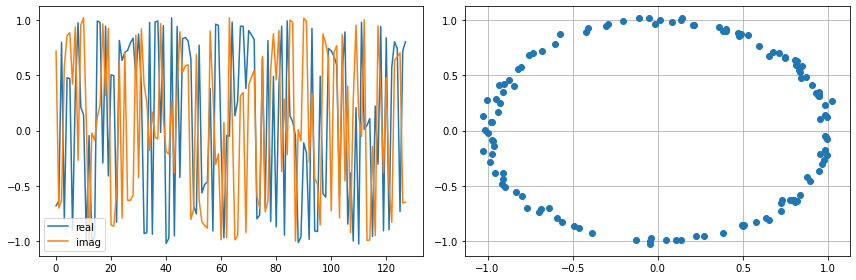

In [15]:
samples, _ = generate_qpsk(128)
# samples = np.ones(100)+1j*np.zeros(100)

offset_sine = np.exp(1j*2*np.pi*(1e4/1e6)*np.arange(len(samples)))
samples = samples*offset_sine

samples = awgn(samples,30)

fix, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(samples.real); ax[0].plot(samples.imag)
ax[1].plot(samples.real, samples.imag, 'o')
# ax[0].plot(np.angle(offset_sine)/np.pi)
# ax[0].plot(np.angle(offset_sine))
# ax[0].plot(offset_sine.real)
# ax[0].plot(offset_sine.imag)
ax[1].grid()
ax[0].legend(('real', 'imag', 'sin r', 'sin i'))
plt.tight_layout()

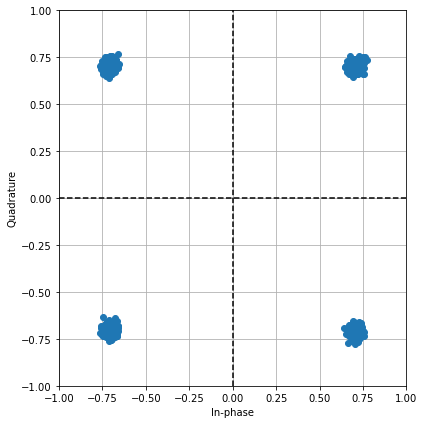

In [24]:
symbols, _ = generate_qpsk(1000)
symbols = awgn(symbols,30)
plt.figure(figsize=(6,6))
plt.plot(symbols.real, symbols.imag, 'o')
plt.grid()
plt.ylim((-1,1));plt.xlim((-1,1))
plt.axvline(0, color='black', linestyle='dashed')
plt.axhline(0, color='black', linestyle='dashed')
plt.xlabel('In-phase'); plt.ylabel('Quadrature')
# plt.title('QPSK Symbols')
plt.tight_layout()
plt.savefig('figures/qpsk_30db.png', dpi=300, bbox_inches='tight')

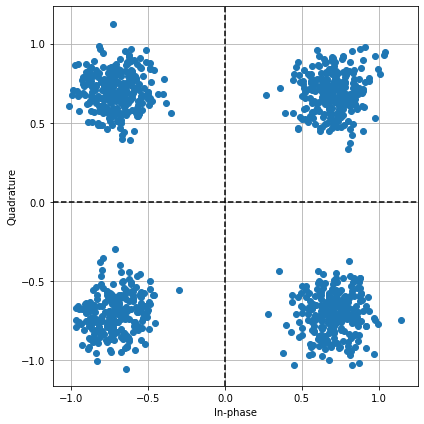

In [25]:
symbols, _ = generate_qpsk(1000)
symbols = awgn(symbols,15)
plt.figure(figsize=(6,6))
plt.plot(symbols.real, symbols.imag, 'o')
plt.grid()
plt.xlabel('In-phase'); plt.ylabel('Quadrature')
plt.axvline(0, color='black', linestyle='dashed')
plt.axhline(0, color='black', linestyle='dashed')
plt.tight_layout()
plt.savefig('figures/qpsk_15db.png', dpi=300, bbox_inches='tight')

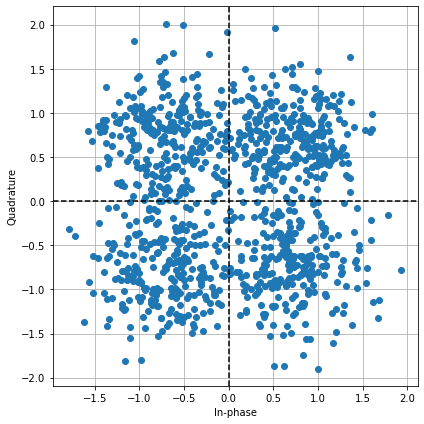

In [26]:
symbols, _ = generate_qpsk(1000)
symbols = awgn(symbols,5)
plt.figure(figsize=(6,6))
plt.plot(symbols.real, symbols.imag, 'o')
plt.grid()
plt.xlabel('In-phase'); plt.ylabel('Quadrature')
plt.axvline(0, color='black', linestyle='dashed')
plt.axhline(0, color='black', linestyle='dashed')
plt.tight_layout()
plt.savefig('figures/qpsk_5db.png', dpi=300, bbox_inches='tight')

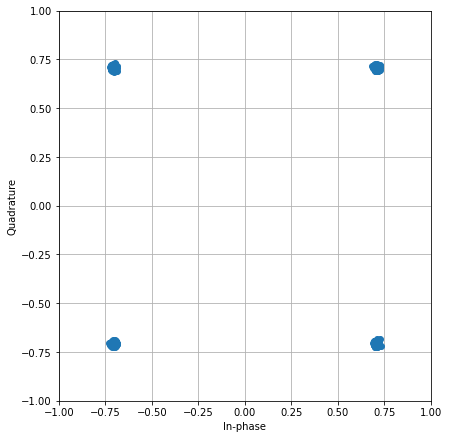

In [28]:
symbols, _ = generate_qpsk(1000)
symbols = awgn(symbols,40)
plt.figure(figsize=(6,6))
plt.plot(symbols.real, symbols.imag, 'o')
plt.grid()
# plt.title('QPSK Symbols')
plt.tight_layout()
plt.ylim((-1,1));plt.xlim((-1,1))
plt.xlabel('In-phase'); plt.ylabel('Quadrature')
plt.savefig('figures/qpsk_clean.png', dpi=300, bbox_inches='tight')

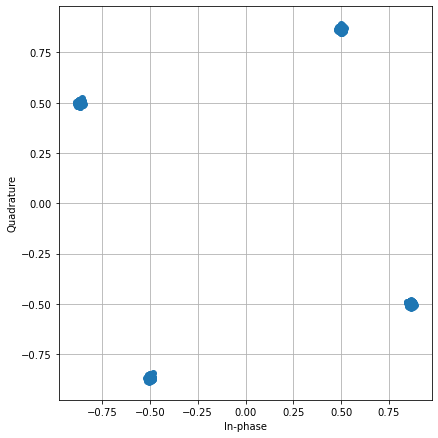

In [31]:
symbols, _ = generate_qpsk(1000)
symbols = awgn(phase_offset(symbols,15),40)
plt.figure(figsize=(6,6))
plt.plot(symbols.real, symbols.imag, 'o')
plt.grid()
# plt.title('QPSK Symbols')
plt.tight_layout()
plt.xlabel('In-phase'); plt.ylabel('Quadrature')
plt.savefig('figures/qpsk_phase_offset.png', dpi=300, bbox_inches='tight')

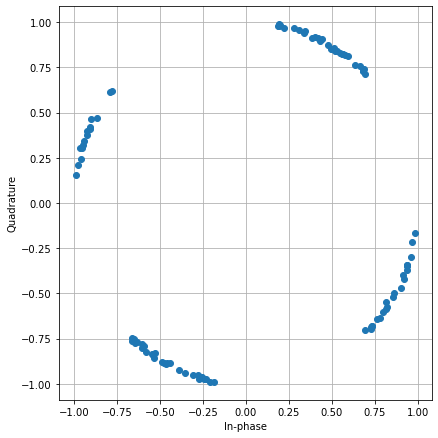

In [30]:
samples, _ = generate_qpsk(100)
# samples = np.ones(100)+1j*np.zeros(100)

offset_sine = np.exp(1j*2*np.pi*(1e3/1e6)*np.arange(len(samples)))
samples = samples*offset_sine

samples = awgn(samples,40)

plt.figure(figsize=(6,6))
plt.plot(samples.real, samples.imag, 'o')
plt.grid()
plt.tight_layout()
plt.xlabel('In-phase'); plt.ylabel('Quadrature')
plt.savefig('figures/qpsk_freq_offset.png', dpi=300, bbox_inches='tight')

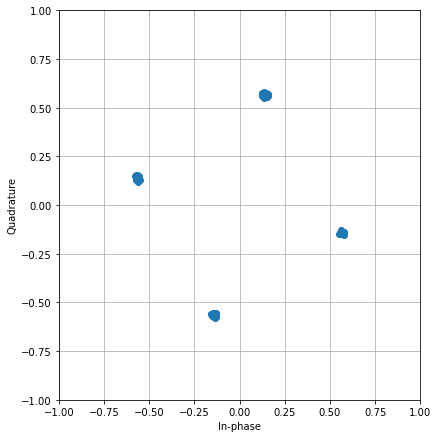

In [67]:
samples, _ = generate_qpsk(100)
# samples = np.ones(100)+1j*np.zeros(100)

complex_weight = [0.3-0.5j]
samples = np.convolve(samples,complex_weight)

samples = awgn(samples,40)

plt.figure(figsize=(6,6))
plt.plot(samples.real, samples.imag, 'o')
plt.grid()
plt.ylim((-1,1)); plt.xlim((-1,1))
plt.tight_layout()
plt.xlabel('In-phase'); plt.ylabel('Quadrature')
plt.savefig('figures/flat_channel.png', dpi=300, bbox_inches='tight')

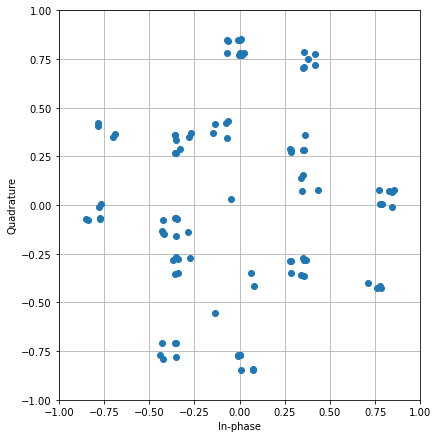

In [69]:
samples, _ = generate_qpsk(100)
# samples = np.ones(100)+1j*np.zeros(100)

complex_weight = [0.3-0.5j, 0.05+0.3j, 0.05+0.001j]
samples = np.convolve(samples,complex_weight)

samples = awgn(samples,40)

plt.figure(figsize=(6,6))
plt.plot(samples.real, samples.imag, 'o')
plt.grid()
plt.ylim((-1,1)); plt.xlim((-1,1))
plt.tight_layout()
plt.xlabel('In-phase'); plt.ylabel('Quadrature')
plt.savefig('figures/multipath_channel.png', dpi=300, bbox_inches='tight')

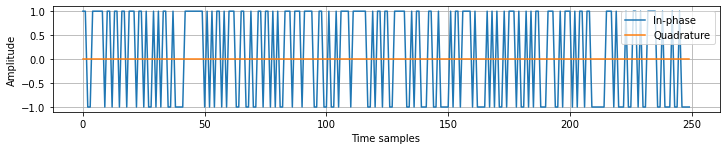

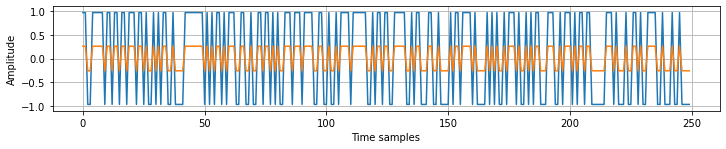

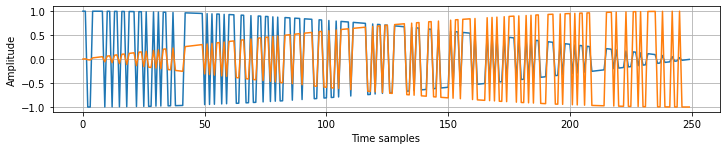

In [66]:
samples, _ = generate_bpsk(250)
# samples = np.ones(100)+1j*np.zeros(100)

offset_sine = np.exp(1j*2*np.pi*(1e3/1e6)*np.arange(len(samples)))
offset_samples = samples*offset_sine
phase_samples = phase_offset(samples,15)

# samples = awgn(samples,40)

# plt.figure(figsize=(6,6))
fig = plt.figure(figsize=(10,2))
plt.plot(samples.real)
plt.plot(samples.imag)
plt.grid()
plt.tight_layout()
plt.xlabel('Time samples'); plt.ylabel('Amplitude')
plt.legend(['In-phase', 'Quadrature'])
plt.ylim([-1.1,1.1])
plt.savefig('figures/cfo_time_domain_1.png', dpi=300, bbox_inches='tight')

fig = plt.figure(figsize=(10,2))
plt.plot(phase_samples.real)
plt.plot(phase_samples.imag)
plt.grid()
plt.tight_layout()
plt.xlabel('Time samples'); plt.ylabel('Amplitude')
plt.ylim([-1.1,1.1])
plt.savefig('figures/cfo_time_domain_2.png', dpi=300, bbox_inches='tight')

fig = plt.figure(figsize=(10,2))
plt.plot(offset_samples.real)
plt.plot(offset_samples.imag)
plt.grid()
plt.tight_layout()
plt.xlabel('Time samples'); plt.ylabel('Amplitude')
plt.ylim([-1.1,1.1])
plt.savefig('figures/cfo_time_domain_3.png', dpi=300, bbox_inches='tight')

# plt.figure(figsize=(5,5))
# plt.plot(samples.real, samples.imag, 'o')
# plt.plot(phase_samples.real, phase_samples.imag, 'o')
# plt.grid()
# plt.show()

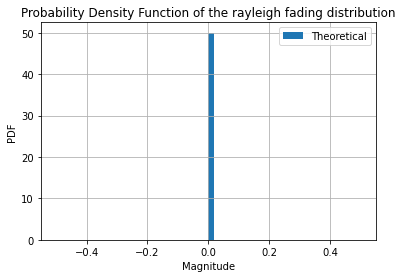

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rayleigh

number_of_realizations = int(10000) #simulate this amount of packets, increase this number for a smoother BER curve
points = int(31) 

channels=np.zeros((points,number_of_realizations),dtype=complex)

# plot amplitude distribution of the rayleigh fading for one SNR value
r=np.abs(channels[10,:]) #Calculate amplitude distribution for the SNR=0dB
rv = rayleigh(loc=0,scale=1/np.sqrt(2)) #Generate theoretical rayleigh distribution
x = np.linspace(r.min(),r.max(), 1000)

myfig = plt.figure()
plt.hist(r,density=True, histtype='stepfilled',bins=50, alpha=1) #Plot histogram
# plt.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf') #Plot theoretical distribution
plt.grid(True)
plt.ylabel('PDF')
plt.xlabel('Magnitude')
plt.title('Probability Density Function of the rayleigh fading distribution')
plt.legend(['Theoretical','Simulated'])
plt.show()
# plt.savefig('Rayleigh_distribution_for_0dB.eps',format='eps')

In [32]:
gains = 1/np.sqrt(2)*(np.random.normal(0, size=(1000000,))+\
                      1j*np.random.normal(0, size=(1000000,)))

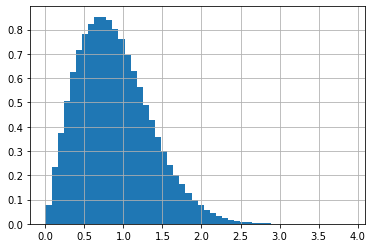

In [33]:
plt.hist(np.abs(gains), density=True, histtype='stepfilled',bins=50)
plt.grid()
plt.show()

In [4]:
z

array([-1.01497973+0.37890021j, -1.01596217+0.3786161j ,
       -1.01694408+0.37833219j, ...,  0.12561888+1.64382247j,
        0.12708139+1.64366099j,  0.12854446+1.64349825j])

max Doppler shift: 17.8816


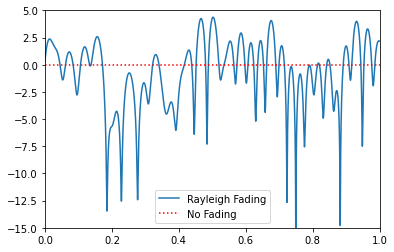

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation Params, feel free to tweak these
v_mph = 60 # velocity of either TX or RX, in miles per hour
center_freq = 200e6 # RF carrier frequency in Hz
Fs = 1e5 # sample rate of simulation
N = 100 # number of sinusoids to sum

v = v_mph * 0.44704 # convert to m/s
fd = v*center_freq/3e8 # max Doppler shift
print("max Doppler shift:", fd)
t = np.arange(0, 1, 1/Fs) # time vector. (start, stop, step)
x = np.zeros(len(t))
y = np.zeros(len(t))
for i in range(N):
    alpha = (np.random.rand() - 0.5) * 2 * np.pi
    phi = (np.random.rand() - 0.5) * 2 * np.pi
    x = x + np.random.randn() * np.cos(2 * np.pi * fd * t * np.cos(alpha) + phi)
    y = y + np.random.randn() * np.sin(2 * np.pi * fd * t * np.cos(alpha) + phi)

# z is the complex coefficient representing channel, you can think of this as a phase shift and magnitude scale
z = (1/np.sqrt(N)) * (x + 1j*y) # this is what you would actually use when simulating the channel
z_mag = np.abs(z) # take magnitude for the sake of plotting
z_mag_dB = 10*np.log10(z_mag) # convert to dB

# Plot fading over time
plt.plot(t, z_mag_dB)
plt.plot([0, 1], [0, 0], ':r') # 0 dB
plt.legend(['Rayleigh Fading', 'No Fading'])
plt.axis([0, 1, -15, 5])
plt.show()